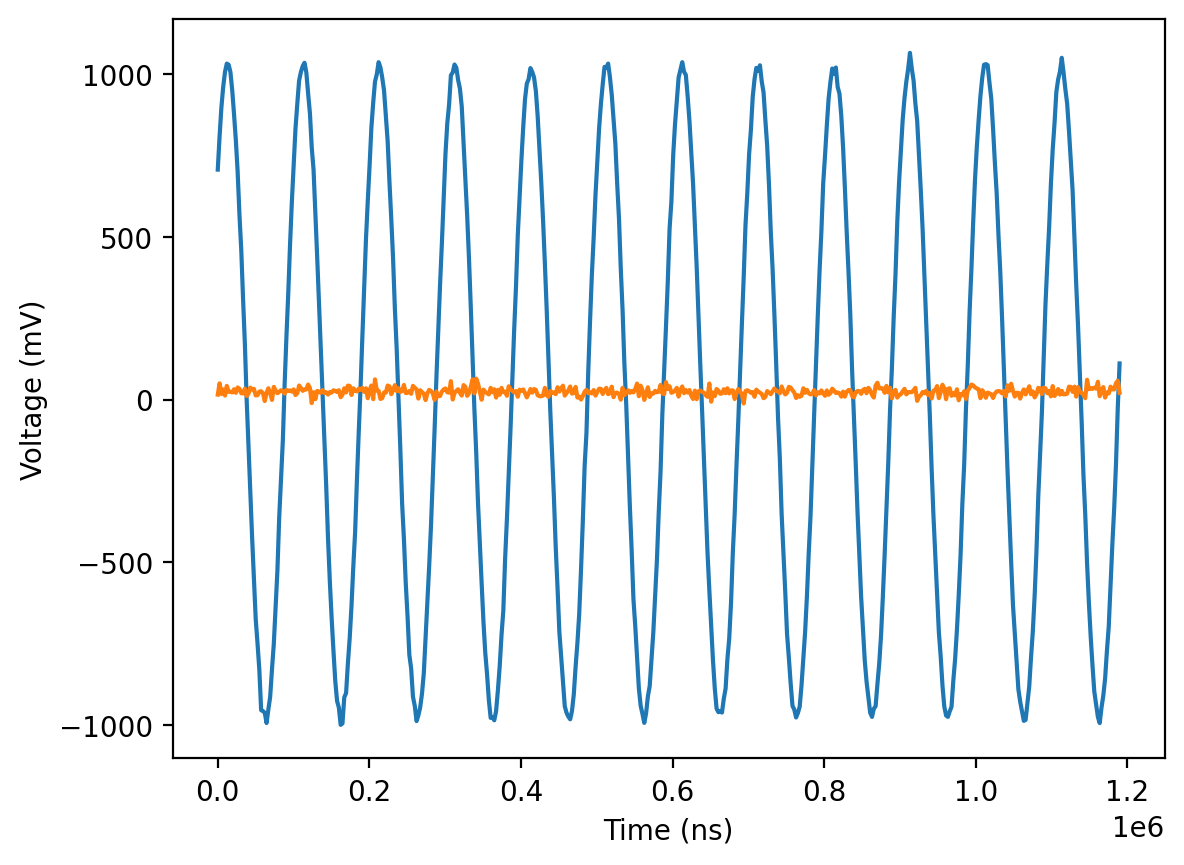

{'openunit': 282, 'changePowerSource': 0, 'setChA': 0, 'setChB': 0, 'maximumValue': 0, 'trigger': 0, 'getTimebase2': 0, 'setSigGenBuiltInV2': 0, 'runBlock': 0, 'isReady': 0, 'setDataBuffersA': 0, 'setDataBuffersB': 0, 'getValues': 0, 'stop': 0, 'close': 0}


In [10]:
#
# Copyright (C) 2018-2022 Pico Technology Ltd. See LICENSE file for terms.
#
# PS5000A BLOCK MODE EXAMPLE
# This example opens a 5000a driver device, sets up two channels and a trigger then collects a block of data.
# This data is then plotted as mV against time in ns.

import ctypes
import numpy as np
from picosdk.ps5000a import ps5000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok, mV2adc

# Create chandle and status ready for use
chandle = ctypes.c_int16()
status = {}

# Open 5000 series PicoScope
resolution =ps.PS5000A_DEVICE_RESOLUTION["PS5000A_DR_14BIT"]
# Returns handle to chandle for use in future API functions
status["openunit"] = ps.ps5000aOpenUnit(ctypes.byref(chandle), None, resolution)

try:
    assert_pico_ok(status["openunit"])
except: # PicoNotOkError:

    powerStatus = status["openunit"]

    if powerStatus == 286:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    elif powerStatus == 282:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    else:
        raise

    assert_pico_ok(status["changePowerSource"])

# Set up channel A
# handle = chandle
channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
# enabled = 1
coupling_type = ps.PS5000A_COUPLING["PS5000A_DC"]
chARange = ps.PS5000A_RANGE["PS5000A_5V"]
# analogue offset = 0 V
status["setChA"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type, chARange, 0)
assert_pico_ok(status["setChA"])

# Set up channel B
# handle = chandle
channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
# enabled = 1
# coupling_type = ps.PS5000A_COUPLING["PS5000A_DC"]
chBRange = ps.PS5000A_RANGE["PS5000A_5V"]
# analogue offset = 0 V
status["setChB"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type, chBRange, 0)
assert_pico_ok(status["setChB"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps5000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

# Set up single trigger
# handle = chandle
# enabled = 1
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
threshold = int(mV2adc(500,chARange, maxADC))
# direction = PS5000A_RISING = 2
# delay = 0 s
# auto Trigger = 1000 ms
status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 1000)
assert_pico_ok(status["trigger"])

# Set number of pre and post trigger samples to be collected
preTriggerSamples = 250
postTriggerSamples = 250
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# Warning: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle
timebase = 300
# noSamples = maxSamples
# pointer to timeIntervalNanoseconds = ctypes.byref(timeIntervalns)
# pointer to maxSamples = ctypes.byref(returnedMaxSamples)
# segment index = 0
timeIntervalns = ctypes.c_float()
returnedMaxSamples = ctypes.c_int32()
status["getTimebase2"] = ps.ps5000aGetTimebase2(chandle, timebase, maxSamples, ctypes.byref(timeIntervalns), ctypes.byref(returnedMaxSamples), 0)
assert_pico_ok(status["getTimebase2"])

# Output signal generator
wavetype = ctypes.c_int32(0)
sweepType = ctypes.c_int32(0)
triggertype = ctypes.c_int32(0)
triggerSource = ctypes.c_int32(0)

status["setSigGenBuiltInV2"] = ps.ps5000aSetSigGenBuiltInV2(chandle, 0, 2000000, wavetype, 10000, 10000, 0, 1, sweepType, 0, 0, 0, triggertype, triggerSource, 0)
assert_pico_ok(status["setSigGenBuiltInV2"])


# Run block capture
# handle = chandle
# number of pre-trigger samples = preTriggerSamples
# number of post-trigger samples = PostTriggerSamples
# timebase = 8 = 80 ns (see Programmer's guide for mre information on timebases)
# time indisposed ms = None (not needed in the example)
# segment index = 0
# lpReady = None (using ps5000aIsReady rather than ps5000aBlockReady)
# pParameter = None
status["runBlock"] = ps.ps5000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, None, 0, None, None)
assert_pico_ok(status["runBlock"])

# Check for data collection to finish using ps5000aIsReady
ready = ctypes.c_int16(0)
check = ctypes.c_int16(0)
while ready.value == check.value:
    status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))


# Create buffers ready for assigning pointers for data collection
bufferAMax = (ctypes.c_int16 * maxSamples)()
bufferAMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example
bufferBMax = (ctypes.c_int16 * maxSamples)()
bufferBMin = (ctypes.c_int16 * maxSamples)() # used for downsampling which isn't in the scope of this example

# Set data buffer location for data collection from channel A
# handle = chandle
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
# pointer to buffer max = ctypes.byref(bufferAMax)
# pointer to buffer min = ctypes.byref(bufferAMin)
# buffer length = maxSamples
# segment index = 0
# ratio mode = PS5000A_RATIO_MODE_NONE = 0
status["setDataBuffersA"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxSamples, 0, 0)
assert_pico_ok(status["setDataBuffersA"])

# Set data buffer location for data collection from channel B
# handle = chandle
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
# pointer to buffer max = ctypes.byref(bufferBMax)
# pointer to buffer min = ctypes.byref(bufferBMin)
# buffer length = maxSamples
# segment index = 0
# ratio mode = PS5000A_RATIO_MODE_NONE = 0
status["setDataBuffersB"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxSamples, 0, 0)
assert_pico_ok(status["setDataBuffersB"])

# create overflow loaction
overflow = ctypes.c_int16()
# create converted type maxSamples
cmaxSamples = ctypes.c_int32(maxSamples)

# Retried data from scope to buffers assigned above
# handle = chandle
# start index = 0
# pointer to number of samples = ctypes.byref(cmaxSamples)
# downsample ratio = 0
# downsample ratio mode = PS5000A_RATIO_MODE_NONE
# pointer to overflow = ctypes.byref(overflow))
status["getValues"] = ps.ps5000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
assert_pico_ok(status["getValues"])


# convert ADC counts data to mV
adc2mVChAMax =  adc2mV(bufferAMax, chARange, maxADC)
adc2mVChBMax =  adc2mV(bufferBMax, chBRange, maxADC)

# Create time data
time = np.linspace(0, (cmaxSamples.value - 1) * timeIntervalns.value, cmaxSamples.value)

# plot data from channel A and B
plt.figure(dpi=200)
plt.plot(time, adc2mVChAMax[:])
plt.plot(time, adc2mVChBMax[:])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (mV)')
plt.show()

# Stop the scope
# handle = chandle
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])

# Close unit Disconnect the scope
# handle = chandle
status["close"]=ps.ps5000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# display status returns
print(status)